# School utilization

We frequently hear from NIMBYs that we shouldn't allow more construction of apartments because it would create a tax burden on our city to accept more students. I don't really like this rhetoric, besides it being a sign of a lack of confidence, it's a degrowth opinion, and a sign of open bigotry against families.

I am also more interested in the practical question of whether or not the net fiscal impact of dense building is positive and whether we can afford to have more students because the tax base has expanded.

In [10]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## The data

Unfortunately I know of no GIS shapefile with Waltham's school district boundaries, so I'm dependent on translating a jpg image of the district boundaries (from here on, a raster image) to a vector layer that I can more easily align to a Waltham parcel layer.

I'm using this as a reference:
https://www.walthampublicschools.org/page/parent-information-center

The best way to get this into the proper location in GIS is to use something like the Georeferencer tool in QGIS. It's pretty easy - open the tool, load the raster, then click on the raster to add a point. The dialog has a button to let you pick a point from a layer loaded in your project, and snapping will make this very easy. Work your way around clockwise until you have a handful of points:

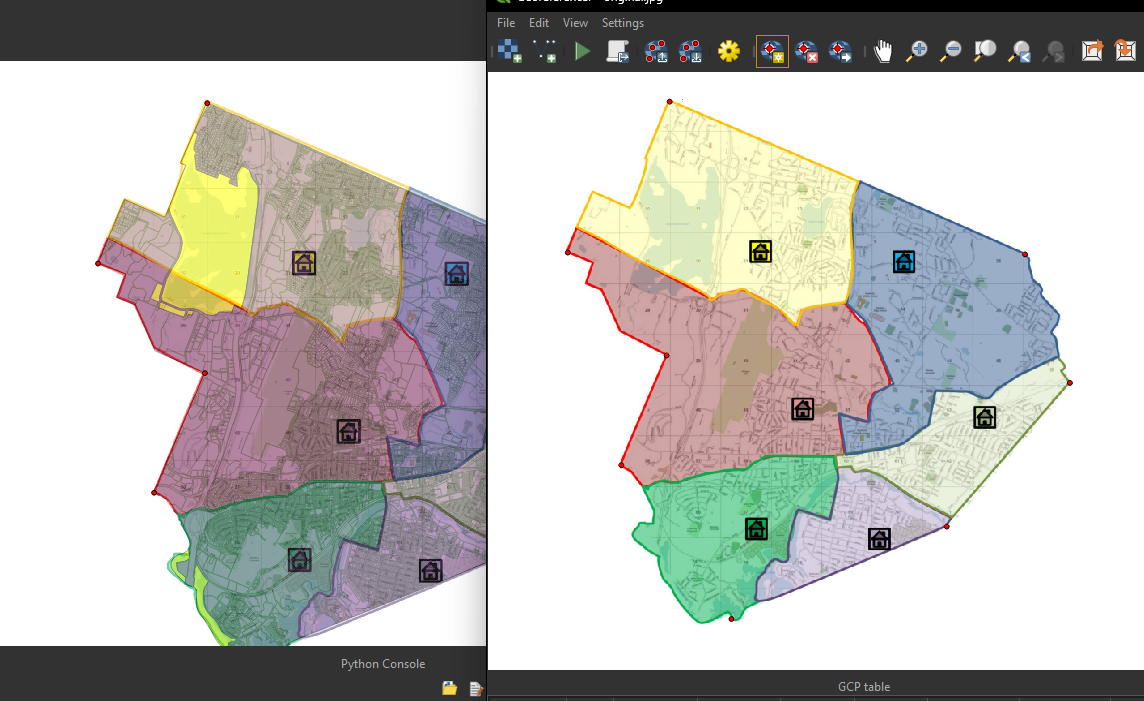

Once you've done that, choose where you want to save it and then perform the georeference. If you then make the layer translucent, you can see how well the alignment worked.

## Drawing district boundaries

From here, we create a new layer and use drawing tools to create new polygons in the outline of the districts. If you turn on snapping, you can ensure there are no gaps or overlaps between districts. Just try to approximate the boundaries. They're mostly along roads anyways.

There's probably more accurate ways to do it, but once we do all of that drawing in QGIS and intersect with a parcel layer, we can get this result:

## Character of the housing in each school zone

Are some school zones more single family homes, or more multi-family homes? A histogram (of the UNITS field in parcels in the 1XX USE CODE range) answers that question readily.

In [3]:
df = gpd.read_file("investigations/school_capacities/school_assigned_parcels2.shp")
df["USE_CODE"] = df["USE_CODE"].fillna("0")
df["USE_CODE"] = df["USE_CODE"].astype(int)

keep_cols = [
    "elem_sch",
    "middle_sch",
    "STYLE",
    "UNITS",
    "USE_CODE",
    "geometry",
    "NUM_ROOMS"
]

df = df[keep_cols]

df = df[(df["USE_CODE"] >= 100) & (df["USE_CODE"] < 200)]

df.head()

,elem_sch,middle_sch,STYLE,UNITS,USE_CODE,geometry,NUM_ROOMS
0,Stanley,McDevitt,COLONIAL,1.0,101,"POLYGON ((219505.564 900503.954, 219494.634 90...",5.0
1,Stanley,McDevitt,TWO FAMILY,2.0,104,"POLYGON ((219512.577 900522.214, 219490.635 90...",17.0
2,Stanley,McDevitt,None,0.0,132,"POLYGON ((220199.657 900534.011, 220200.914 90...",0.0
3,Stanley,McDevitt,RANCH,1.0,101,"POLYGON ((219483.941 900549.005, 219481.135 90...",5.0
4,Stanley,McDevitt,COLONIAL,1.0,101,"POLYGON ((219524.316 900552.801, 219523.399 90...",7.0


In [4]:
df[df["UNITS"] > 100]

,elem_sch,middle_sch,STYLE,UNITS,USE_CODE,geometry,NUM_ROOMS
337,Whittemore,McDevitt,APARTMENTS,150.0,112,"POLYGON ((221848.243 902543.765, 221875.35 902...",7.0
1850,FitzGerald,McDevitt,LUX. APART.,200.0,112,"POLYGON ((223394.403 901974.832, 223271.771 90...",13.0
1851,Whittemore,McDevitt,LUX. APART.,200.0,112,"POLYGON ((223369.17 901897.193, 223324.792 901...",13.0
2218,Stanley,McDevitt,LUX APT-HR,147.0,112,"POLYGON ((220736.468 902079.059, 220732.339 90...",36.0
2238,Stanley,McDevitt,LUX APT-HR,103.0,112,"POLYGON ((220916.146 902084.115, 220905.614 90...",57.0
3240,Whittemore,McDevitt,APARTMENTS,264.0,112,"POLYGON ((222079.387 902436.419, 222052.019 90...",8.0
3805,Whittemore,McDevitt,APARTMENTS,108.0,112,"POLYGON ((221966.166 902521.155, 221944.506 90...",8.0
8454,Plympton,Kennedy,APARTMENTS,195.0,112,"POLYGON ((219260.122 904112.049, 219150.071 90...",11.0
10343,MacArthur,Kennedy,APARTMENTS,315.0,112,"POLYGON ((220209.627 905397.706, 220204.525 90...",0.0
12307,MacArthur,Kennedy,APARTMENTS,707.0,112,"POLYGON ((221706.763 906748.133, 221715.202 90...",12.0


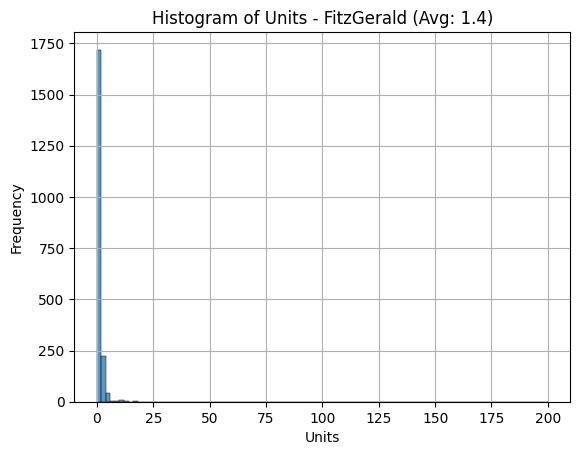

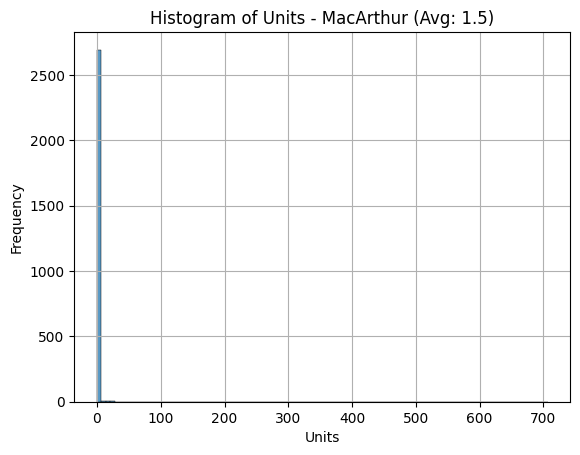

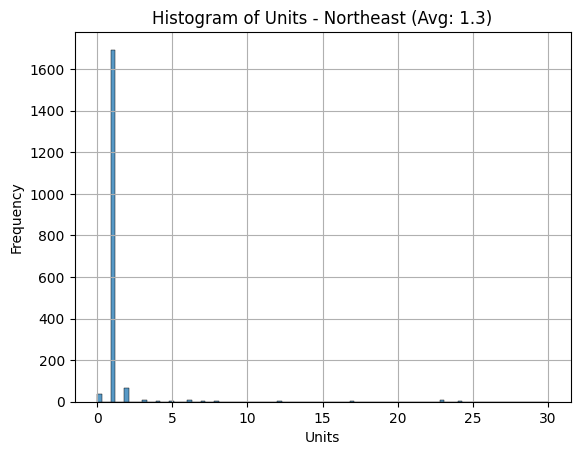

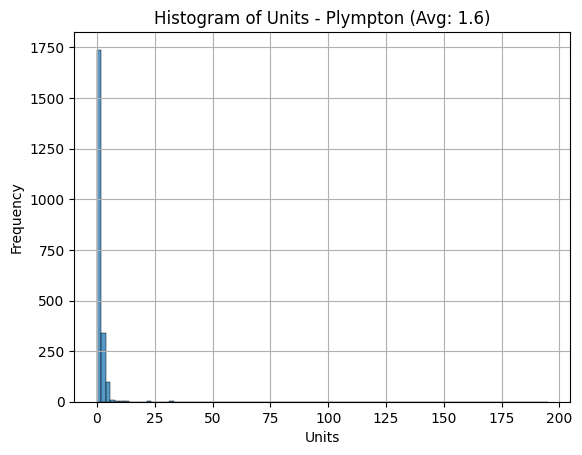

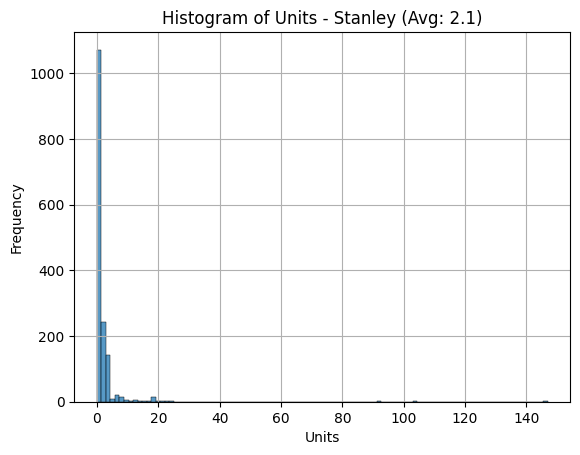

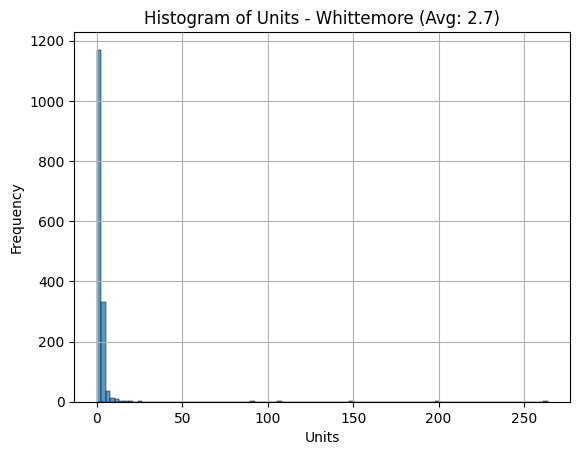

In [5]:
grouped = df.groupby('elem_sch')
for name, group in grouped:
    plt.figure()
    sns.histplot(group['UNITS'], bins = 100, kde=False)
    ave_units = group["UNITS"].mean()
    plt.title(f'Histogram of Units - {name} (Avg: {ave_units:.1f})')
    plt.xlabel('Units')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()


In [6]:
# (the average number of units per district, in one table)
df.groupby('elem_sch').agg({'UNITS': ['mean', 'sum', 'count']}).reset_index()

elem_sch     UNITS              
                   mean     sum count
0  FitzGerald  1.423325  2868.0  2015
1   MacArthur  1.464523  3963.0  2706
2   Northeast  1.315505  2435.0  1851
3    Plympton  1.553895  3431.0  2208
4     Stanley  2.069145  3172.0  1533
5  Whittemore  2.720000  4284.0  1575

### Middle schools

Although we still see a very strong peak at 1 unit per residential structure, it's interesting that McDevitt has a lot more MFH. It would have probably been more representative if Waltham did an east-west split instead of a north-south split for middle school assignments.

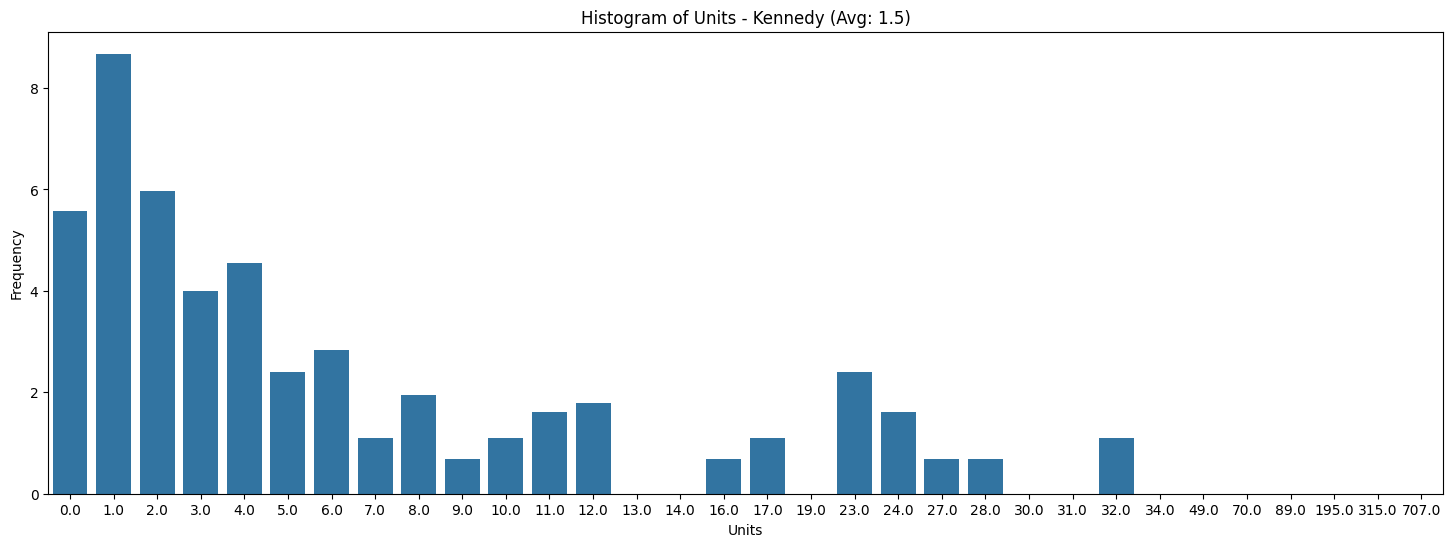

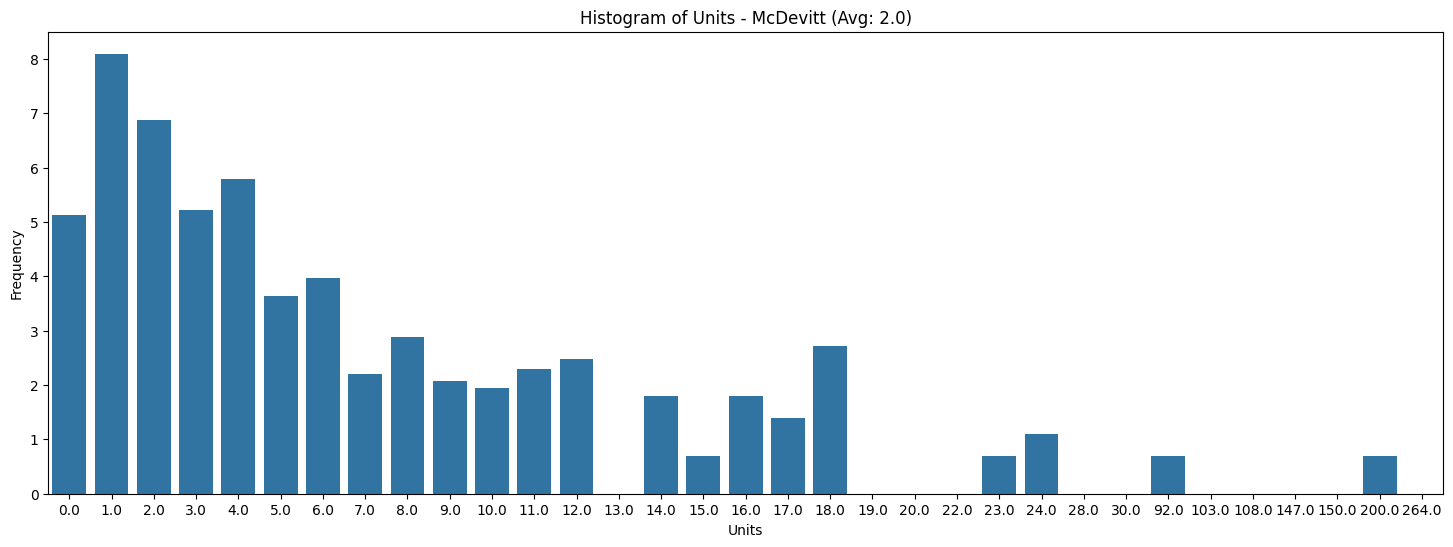

In [ ]:
grouped = df.groupby('middle_sch')
for name, group in grouped:
    plt.figure()
    ax = sns.barplot(x=group['UNITS'].value_counts().index, y=np.log(group['UNITS'].value_counts().values))
    ax.figure.set_size_inches(18, 6)
    ave_units = group["UNITS"].mean()
    plt.title(f'Histogram of Units - {name} (Avg: {ave_units:.1f})')
    plt.xlabel('Units')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()


In [8]:
# (the average number of units per district, in one table)
df.groupby('middle_sch').agg({'UNITS': ['mean', 'sum', 'count']}).reset_index()

middle_sch     UNITS               
                  mean      sum count
0    Kennedy  1.452919   9829.0  6765
1   McDevitt  2.015225  10324.0  5123

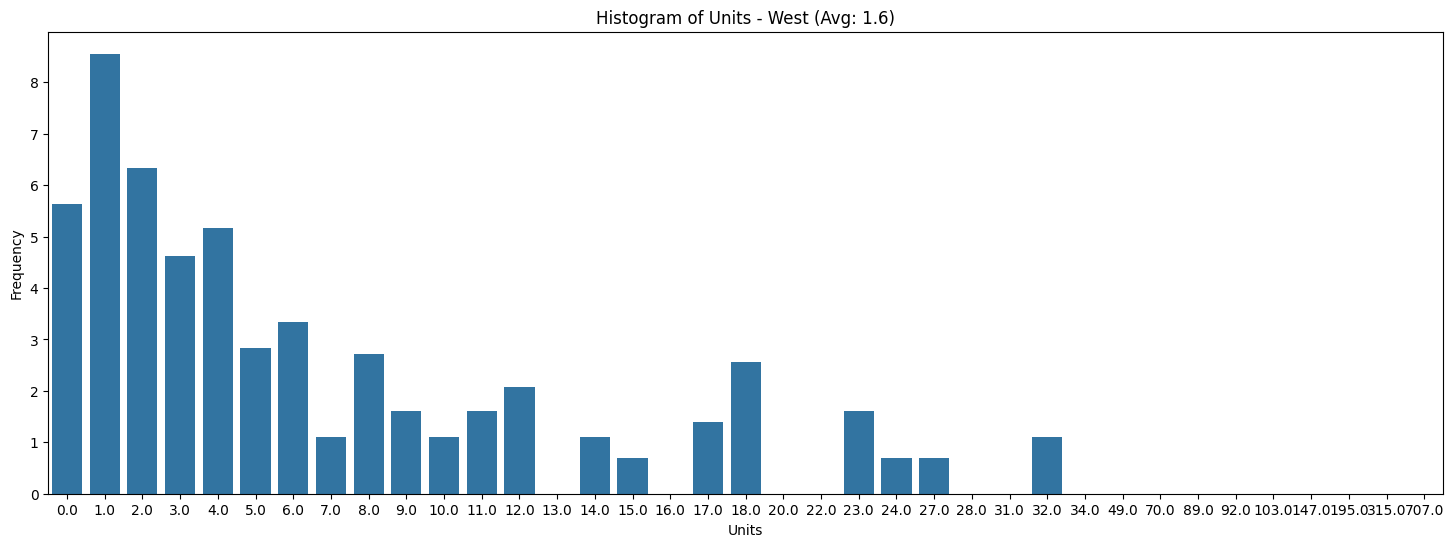

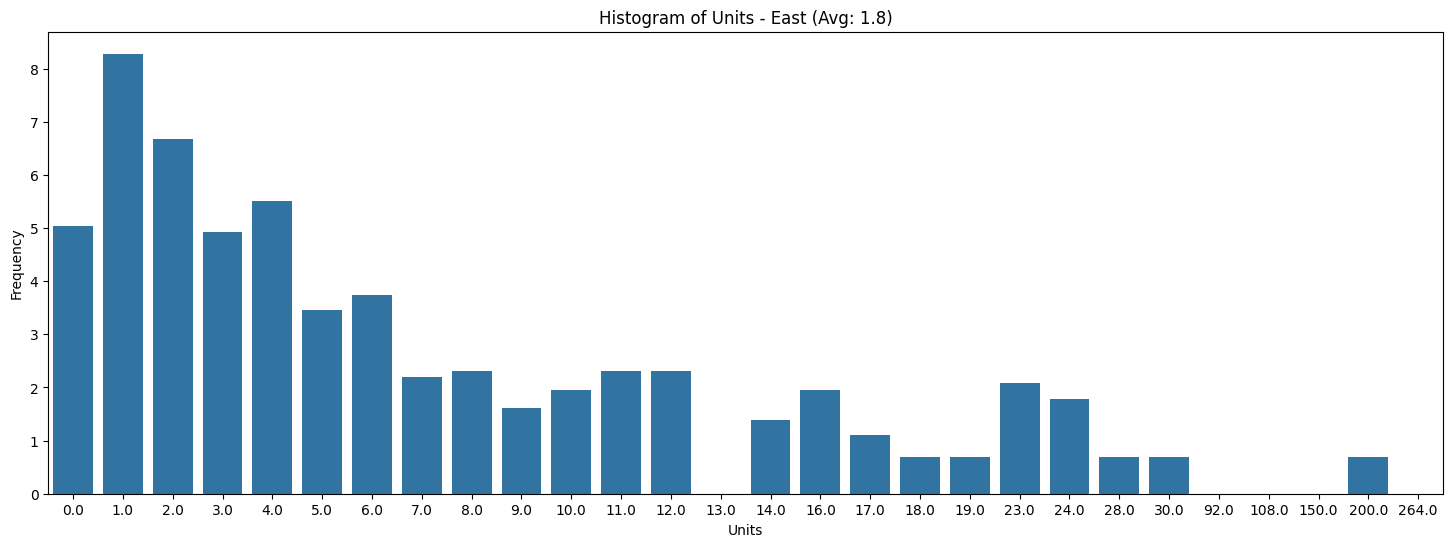

In [ ]:
c = df["elem_sch"].isin(["MacArthur", "Stanley", "Plympton"])

grouped = {"West" : df[c], "East": df[~c]}

for name, group in grouped.items():
    plt.figure()
    ax = sns.barplot(x=group['UNITS'].value_counts().index, y=np.log(group['UNITS'].value_counts().values))
    ax.figure.set_size_inches(18, 6)
    ave_units = group["UNITS"].mean()
    plt.title(f'Histogram of Units - {name} (Avg: {ave_units:.1f})')
    plt.xlabel('Units')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

## Enrollment trends

Data below has been sourced from here:

https://profiles.doe.mass.edu/profiles/student.aspx?orgcode=03080000&orgtypecode=5&

(unfortunately there's no .csv export, had to copy around by hand, so I hope I haven't made any mistakes)

### Waltham as a whole

### Per-elementary district trends

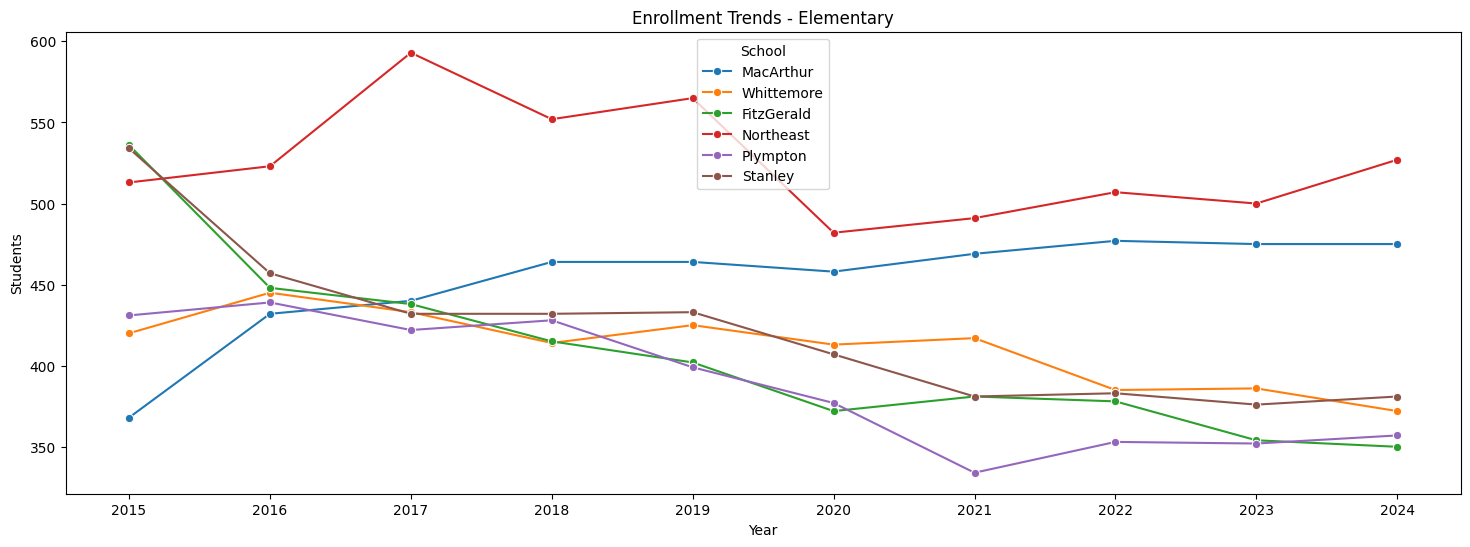

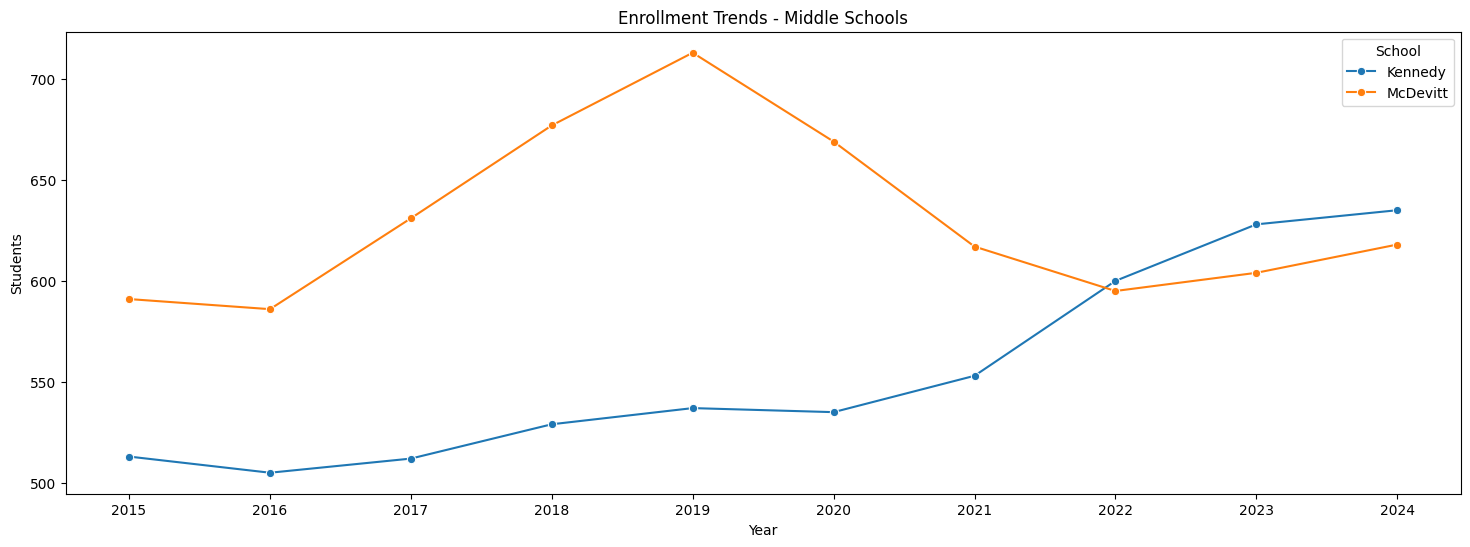

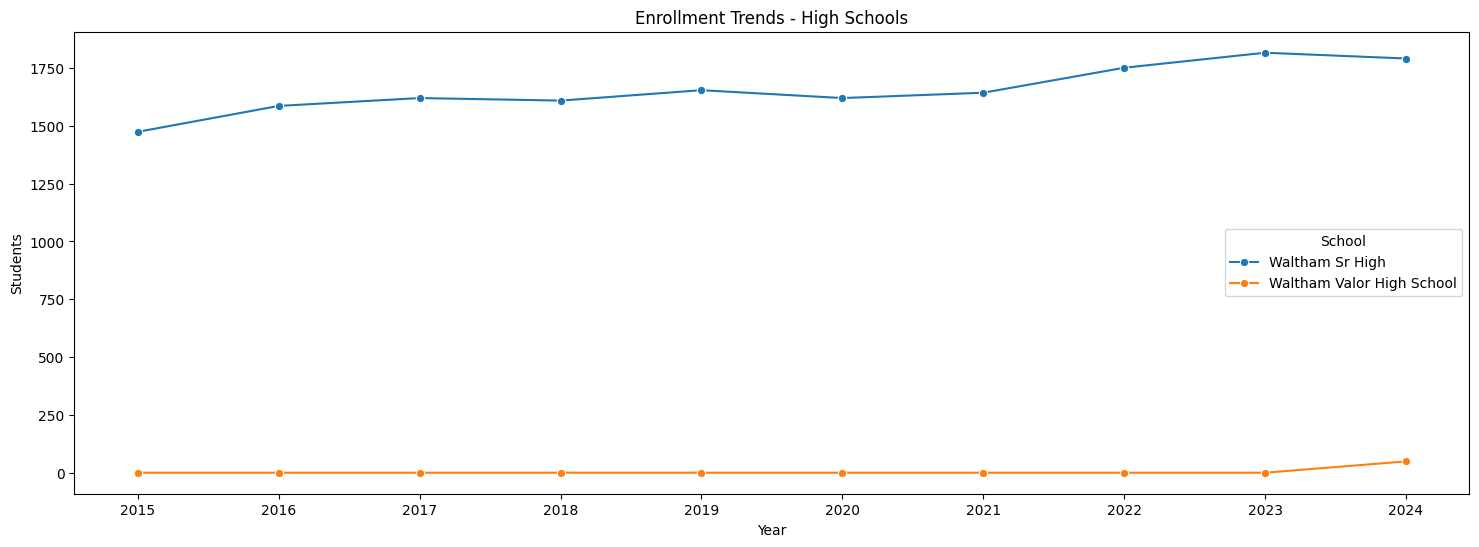

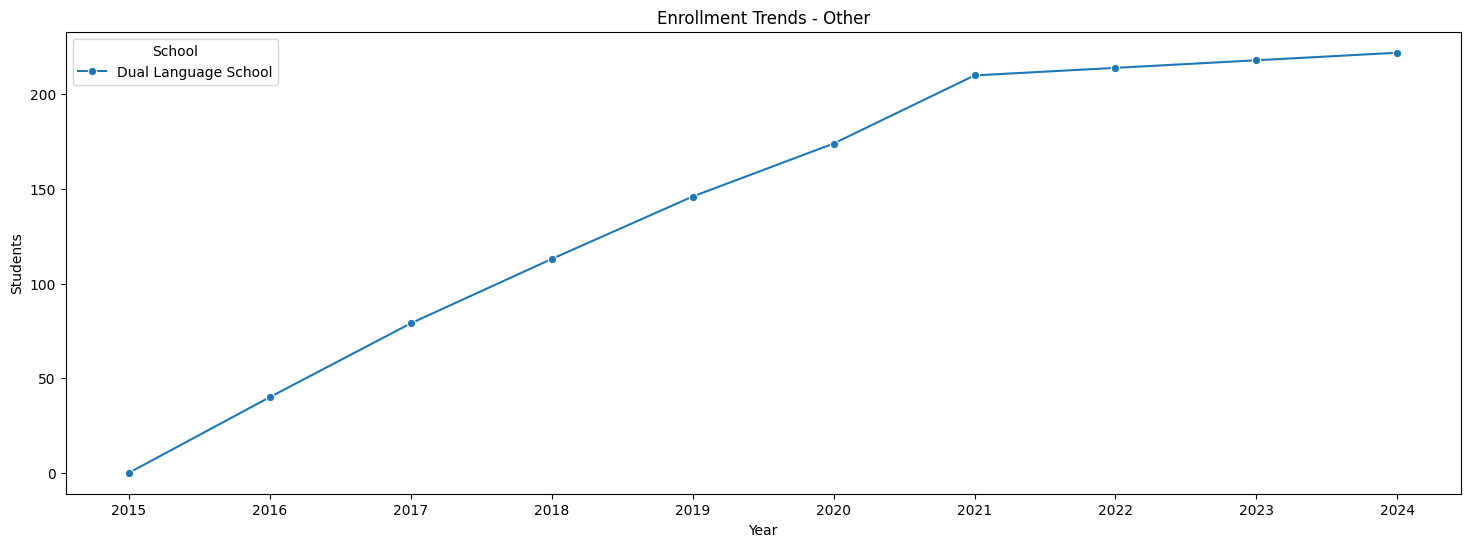

In [ ]:
enrollment_df = pd.read_csv("data/school_enrollment.csv")
enrollment_df["is_elem"] = enrollment_df["School"].isin(["MacArthur", "Stanley", "Plympton", "Northeast", "FitzGerald", "Whittemore"])
enrollment_df["is_middle"] = enrollment_df["School"].isin(["McDevitt", "Kennedy"])
enrollment_df["is_high"] = enrollment_df["School"].isin(["Waltham Sr High", "Waltham Valor High School"])
enrollment_df["is_other"] = ~(enrollment_df["is_elem"] | enrollment_df["is_middle"] | enrollment_df["is_high"])

melted_enrollment_df = enrollment_df.melt(id_vars=['School', "is_elem", "is_middle", "is_high", "is_other"], var_name='Year', value_name='Enrollment')

grouped = {
    "Elementary" : melted_enrollment_df[melted_enrollment_df["is_elem"]],
    "Middle Schools": melted_enrollment_df[melted_enrollment_df["is_middle"]],
    "High Schools": melted_enrollment_df[melted_enrollment_df["is_high"]],
    "Other": melted_enrollment_df[melted_enrollment_df["is_other"]]
}

for school_type, group in grouped.items():
    plt.figure()
    ax = sns.lineplot(data=group, x='Year', y='Enrollment', hue='School', marker='o')
    ax.figure.set_size_inches(18, 6)
    plt.title(f'Enrollment Trends - {school_type}')
    plt.xlabel('Year')
    plt.ylabel('Students')
    plt.grid(True)
    plt.show()

## Students per unit, per school

This is probably the one measure everyone is interested in, but I expect digging deeper the count of the style of structure is more predictive of how many students will end up in a district.

My intuition is that most MFH builds have mostly 1 and 2 bedroom units, with 3 or more bedrooms being rare and expensive (easier for a roommate situation with one income per room vs. parents having to make rent for the kids who aren't paying.)

### Other questions?

If we align this with tax data, we can get an idea of what areas are subsidizing the city vs. the number of students